# Punzi and Signal Purity Scans

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
from joblib import load
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-03-28 14:07:26.951115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 14:07:26.951364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
version = '9.0.5'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

## Load Models

In [3]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
old_nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'OLDNN': old_nn}

2022-03-28 14:08:25.190283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-28 14:08:25.190380: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-28 14:08:25.190421: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-0L9OF1GC): /proc/driver/nvidia/version does not exist
2022-03-28 14:08:25.190818: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/root/envs/scientific/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle esti

## Signal Purity

In [4]:
def get_purity(labels, predictions, p):
    # Of everything I selected how much was correctly ID'd as signal?
    # purity = no. of events selected as signal && signal / no. of events selected
    purities = []
    for j in p:
        classes = np.where(predictions.flatten() > j, 1, 0).flatten()
        purity = np.count_nonzero(np.logical_and(classes, labels))/np.count_nonzero(classes)
        purities.append(purity)
    return np.array(purities)

## Punzi Figure-of-Merit

In [5]:
from scipy.integrate import quad
from scipy.optimize import curve_fit

def cubic(x, p3, p2, p1, p0):
    return p3*x**3 + p2*x**2 + p1*x + p0

def wrapped_cubic(x, N):
    return N*cubic(x, 9.254546221042552e-08, -1.954917162621531e-05, -0.20807214015665842, 208.8967046045883)

In [62]:
def get_punzi(labels, predictions, masses, p, a=5, sregion=[5200, 5800], bins=60, verbose=0):
    punzis = []
    last_nbg, last_nbgmax, last_nbgmin = 0, 0, 0
    for j in p:
        fit_failed = False
        classes = np.where(predictions > j, 1, 0).flatten()
        bg_masses = np.array([m for i, m in enumerate(masses) if (classes[i] == 1) and (labels[i] == 0)])
        # What are the masses of all the events which we said were signal but actually background (got through)
        #sig_masses = np.array([m for i, m in enumerate(masses) if (classes[i]==1) and (labels[i]==1)])
        # What are the masses of all the events which we said were signal and were signal (estimate total amount of signal)
        
        h, bs = np.histogram(bg_masses-5500, bins=bins)
        # shift the cut_masses by 5.5 GeV for fitting reasons
        
        # Refit the residual background
        bin_centres = np.array([np.mean(bs[i:i+2]) for i in range(len(bs)-1)])
        data = np.array([bin_centres, h.flatten(), np.sqrt(h.flatten())]).T
        data = data[data[:,1] != 0]
        # Remove the bins with no data present
        
        efficiency = np.count_nonzero(np.logical_and(classes, labels))/np.count_nonzero(labels)
        # The number of signal events correctly identified divied by the number of signal events
        
        try:
            popt, pcov = curve_fit(wrapped_cubic, data[:,0], data[:,1], [0.05], data[:,2])
        except: # TODO: Tidy us this exception to be more specific
            fit_failed = True

        # Refit the same cubic but just allow a free scaling of it

        ## if the fit fails use up to 5 jumps backwards in the linspace? else do nothing
        if fit_failed:
            nbg = last_nbg
            nbg_min = last_nbgmin
            nbg_max = last_nbgmax
        else:
            nbg = quad(wrapped_cubic, sregion[0]-5500, sregion[1]-5500, args=(popt[0]))[0]
            nbg_max = quad(wrapped_cubic, sregion[0]-5500, sregion[1]-5500, args=(popt[0]+np.sqrt(np.diag(pcov)))[0])[0]
            nbg_min = quad(wrapped_cubic, sregion[0]-5500, sregion[1]-5500, args=(popt[0]-np.sqrt(np.diag(pcov)))[0])[0]
            last_nbg, last_nbgmax, last_nbgmin = nbg, nbg_max, nbg_min
        if verbose != 0:
            print(f'Estimated number of background events\nMax: {nbg_max:.2f} Middle: {nbg:.2f} Min: {nbg_min:.2f}\nFit Status: {not fit_failed}')
        punzi = efficiency/(a/2 + np.sqrt(nbg))
        punzi_min = efficiency/(a/2 + np.sqrt(nbg_max))
        punzi_max = efficiency/(a/2 + np.sqrt(nbg_min)) 
        punzis.append([punzi_min, punzi, punzi_max])
    return np.array(punzis)

## Testing Models

In [110]:
x = np.linspace(0.3, 0.95, 100)
preds = dtc.predict_proba(X_test.to_numpy())[:,1].flatten()

In [111]:
punzis = get_punzi(y_test.to_numpy(), preds, test['Lb_M'], x, bins=40)

In [112]:
purities = get_purity(y_test.to_numpy(), preds, x)

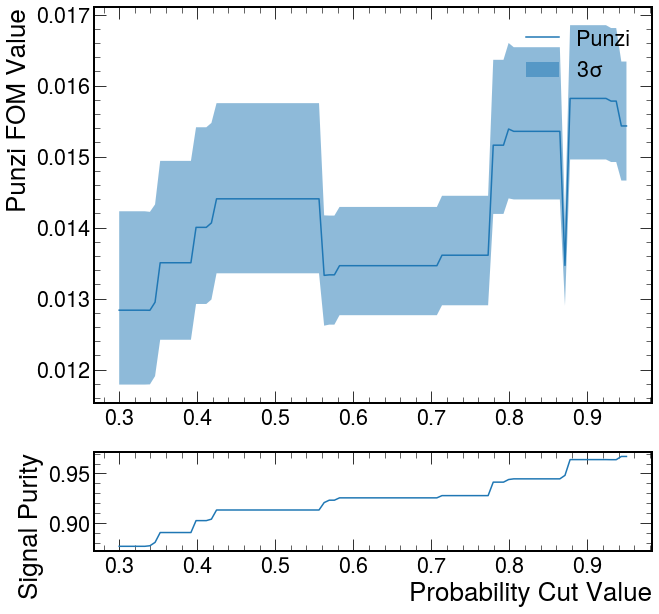

In [113]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})

ax[0].plot(x, punzis[:,1], label='Punzi')
ax[0].fill_between(x, punzis[:,0], punzis[:,2], alpha=0.5, label=r'3$\sigma$')
ax[0].legend()

ax[1].plot(x, purities, label='Purity')
ax[1].set_ylabel('Signal Purity')
ax[0].set_ylabel('Punzi FOM Value')

plt.xlabel('Probability Cut Value')
plt.savefig('../images/ModelEval/DTC_PunziPurity.png', dpi=800)
plt.show()